In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

### Load Copenhagen Network Data

#### Raw Data

In [3]:
bt = pd.read_csv('bt_symmetric.csv', header = 0, names = ['timestamp','user_a', 'user_b', 'rssi'])
bt.head()

,timestamp,user_a,user_b,rssi
0,0,0,-1,0
1,0,1,-1,0
2,0,2,-1,0
3,0,3,-2,-88
4,0,5,-1,0


In [4]:
bt.rssi.describe().round(2)

count    5474289.00
mean         -49.95
std           42.07
min         -107.00
25%          -88.00
50%          -74.00
75%            0.00
max           20.00
Name: rssi, dtype: float64

In [5]:
users = set(bt.user_a.unique().tolist() + bt.user_b.unique().tolist())
users.remove(-2) # non-participating devices
users.remove(-1) # empty scans
print('Number of Pings in Raw Data: ', bt.shape[0])
print('Number of Unique Users in Raw Data: ', len(users))

Number of Pings in Raw Data:  5474289
Number of Unique Users in Raw Data:  706


#### Only Participants

In [11]:
# Drop empty scans (-1) and non-participating devices (-2)
new_bt = bt.copy()
new_bt.drop(bt[bt['user_a'] < 0].index, inplace = True)
new_bt.drop(bt[bt['user_b'] < 0].index, inplace = True)

In [12]:
# Renumber IDs for adjacency matrix
node_ids = list(set(new_bt.user_a.unique().tolist() + new_bt.user_b.unique().tolist()))
new_ids_dict = {node_ids[i]: i for i in range(len(node_ids))}
new_bt['user_a'] = new_bt['user_a'].map(new_ids_dict)
new_bt['user_b'] = new_bt['user_b'].map(new_ids_dict)
len(node_ids)

692

In [13]:
# Save out pre-processed data for simulations
new_bt.to_csv('bt_data_clean.csv', index=False)

#### Only Strong Ties

In [17]:
# Create filtered version
bt75 = new_bt[new_bt.rssi>=-75]
usera = bt75.user_a.unique().tolist()
userb = bt75.user_b.unique().tolist()
print('# of Pings After Dropping Weak Signals: ', bt75.shape[0])
print('% of Total Pings Left: ', bt75.shape[0]/bt.shape[0])
print('# of Pings Dropped due to Weak Signals: ', new_bt.shape[0] - bt75.shape[0])
print('% of Pings Dropped due to Weak Signals: ', (new_bt.shape[0] - bt75.shape[0])/bt.shape[0])
print('# of Users After Dropping Weak Signals: ', len(set(usera+userb)))

# of Pings After Dropping Weak Signals:  438547
% of Total Pings Left:  0.08011031204234924
# of Pings Dropped due to Weak Signals:  1987732
% of Pings Dropped due to Weak Signals:  0.36310322673866874
# of Users After Dropping Weak Signals:  675


In [18]:
bt75.rssi.describe().round(2)

count    438547.00
mean        -68.13
std           7.38
min         -75.00
25%         -74.00
50%         -70.00
75%         -65.00
max          20.00
Name: rssi, dtype: float64

### Look at Interaction Stats

In [19]:
# Create duplicate with users swapped to get accurate user statistics using user_a field
swapdf = bt75.copy()
swapdf['user_a'] = bt75['user_b']
swapdf['user_b'] = bt75['user_a']
swapdf.head()

,timestamp,user_a,user_b,rssi,day
15,0,19,20,-73,0
36,0,47,48,-62,0
67,0,89,90,-60,0
74,0,56,100,-71,0
176,0,11,239,-70,0


In [20]:
# Concatenate the two dataframes and then remove user_b data
userdf = pd.concat([bt75, swapdf], ignore_index = True)
userdf.drop(columns = 'user_b', inplace = True)
userdf.rename(columns={"user_a": "user"}, inplace = True)
userdf.head()

,timestamp,user,rssi,day
0,0,20,-73,0
1,0,48,-62,0
2,0,90,-60,0
3,0,100,-71,0
4,0,239,-70,0


In [21]:
# Average number of interactions per participant per day
# Number of interactions per day / Number of unique active participants
userdf.groupby('day')['timestamp'].count()/userdf.groupby('day')['user'].nunique()

day
0     40.985915
1     74.639130
2     73.944700
3     71.252137
4     77.379775
5     65.241218
6     56.477612
7     48.157480
8     77.500967
9     92.486590
10    86.288462
11    96.451243
12    78.153257
13    60.656716
14    42.232932
15    84.078431
16    87.208835
17    76.560327
18    74.401575
19    76.728395
20    52.020202
21    42.063241
22    79.307847
23    84.779443
24    84.506173
25    73.414433
26    78.078947
27    48.075314
dtype: float64

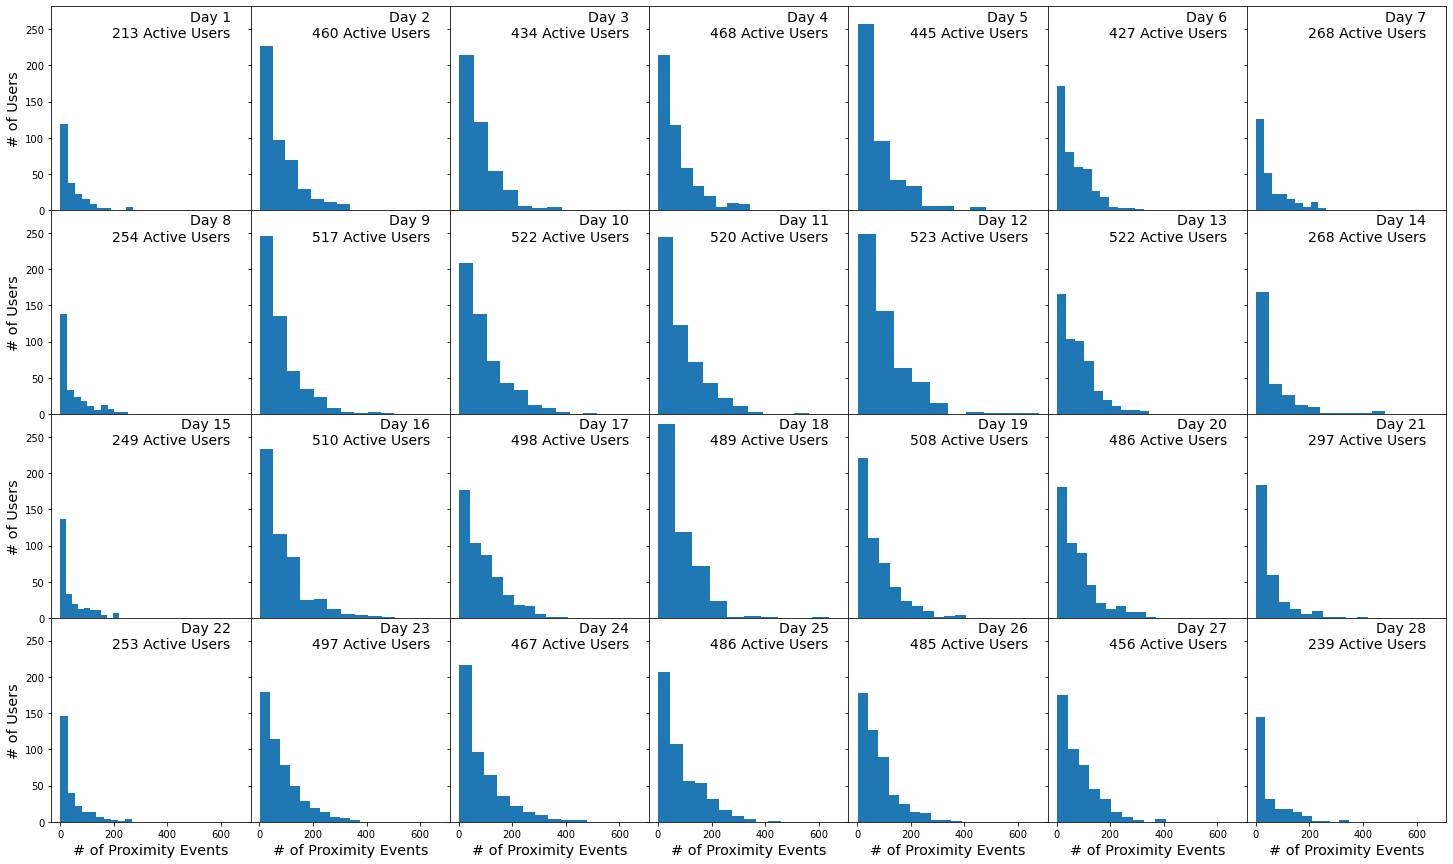

In [22]:
mpl.rcParams['axes.titlesize'] = 'x-large'
mpl.rcParams['axes.labelsize'] = 'x-large'

f, axs = plt.subplots(4, 7, figsize=(25, 15), sharex = True, sharey = True)
f.subplots_adjust(wspace=0, hspace=0)
for (i, day) in enumerate(userdf.day.unique()):
    active = userdf[userdf.day==day]['user'].nunique()
    titletxt = 'Day ' + str(day+1) + '\n' + str(active) + ' Active Users'
    
    axs[i//7,(i-7) % 7].hist(userdf[userdf.day==day].groupby('user')['timestamp'].count())
    axs[i//7,(i-7) % 7].text(0.9, 0.85, titletxt, fontsize = 14, horizontalalignment='right', 
                             transform=axs[i//7,(i-7) % 7].transAxes)
    
    if (i-7)%7==0:
        axs[i//7, (i-7)%7].set_ylabel('# of Users')
    if i//7==3:
        axs[i//7, (i-7)%7].set_xlabel('# of Proximity Events')
        
plt.savefig('CNS_UserActivity_byDay.eps', format = 'eps');

In [23]:
# Average number of interactions per user per day
(userdf['timestamp'].count()/userdf['user'].nunique())/28

46.40708994708995

In [24]:
# Average of number of interactions over entire study period per user
userdf['timestamp'].count()/userdf['user'].nunique()

1299.3985185185186

### Create Daily Networks

In [25]:
def construct_daily_nets(input_file):
    """Read input file and return a dictionary of graphs where edge weight "pings" counts
    the number of times each pair has been observed.
    
    Data format and example:
        timestamp,user_a,user_b,rssi
        0,0,-1,0
        0,1,-1,0
        0,2,-1,0
    
    Some important points:
        -Time is quantized into 5-minute bins and timestamps are reported in the multiples of 300 seconds
        -In bins where userA was actively scanning, but found no other Bluetooth devices in proximity, 
         reported the alter ID as −1 and the received signal strength as 0
        -In bins where userA discovered other Bluetooth devices but not other study participants,
         reported the alter ID as −2 and the highest received signal strength measured.
"""
    counter = 0
    Gs = {}
    stats = {}
    for line in open(input_file):
        counter += 1
        # skip the first (header) line
        if counter > 1:
            # extract input
            line = line.rstrip().split(",")
            timestamp = int(line[0])
            user_a = int(line[1])
            user_b = int(line[2])
            rssi = int(line[3])
            day = timestamp // (24 * 60 * 60)

            # keep statistics for each day
            if day not in stats:
                stats[day] = {"pings":1, "empty":0, "other":0}
            else:
                stats[day]["pings"] += 1

            # create a graph for each day
            if day not in Gs:
                Gs[day] = nx.Graph()
            
            # if user_b is a person in the study, such that user_b >=0, update network
            if user_b >= 0:
                # construct daily graph if RSSI > -75
                if rssi >= -75:
                    # create new edge if needed
                    if not Gs[day].has_edge(user_a, user_b):
                        Gs[day].add_edge(user_a, user_b, pings = 1)
                    # update weight of existing edge
                    else:
                        weight = Gs[day].edges[user_a, user_b]["pings"]
                        Gs[day].add_edge(user_a, user_b, pings = weight + 1)
            
            # if user b is not a person in the study, update stats
            else:
                if user_b == -1:
                    stats[day]["empty"] += 1
                elif user_b == -2:
                    stats[day]["other"] += 1
                
    return (Gs, stats)

input_file = "bt_symmetric.csv"
(Gs, stats) = construct_daily_nets(input_file)

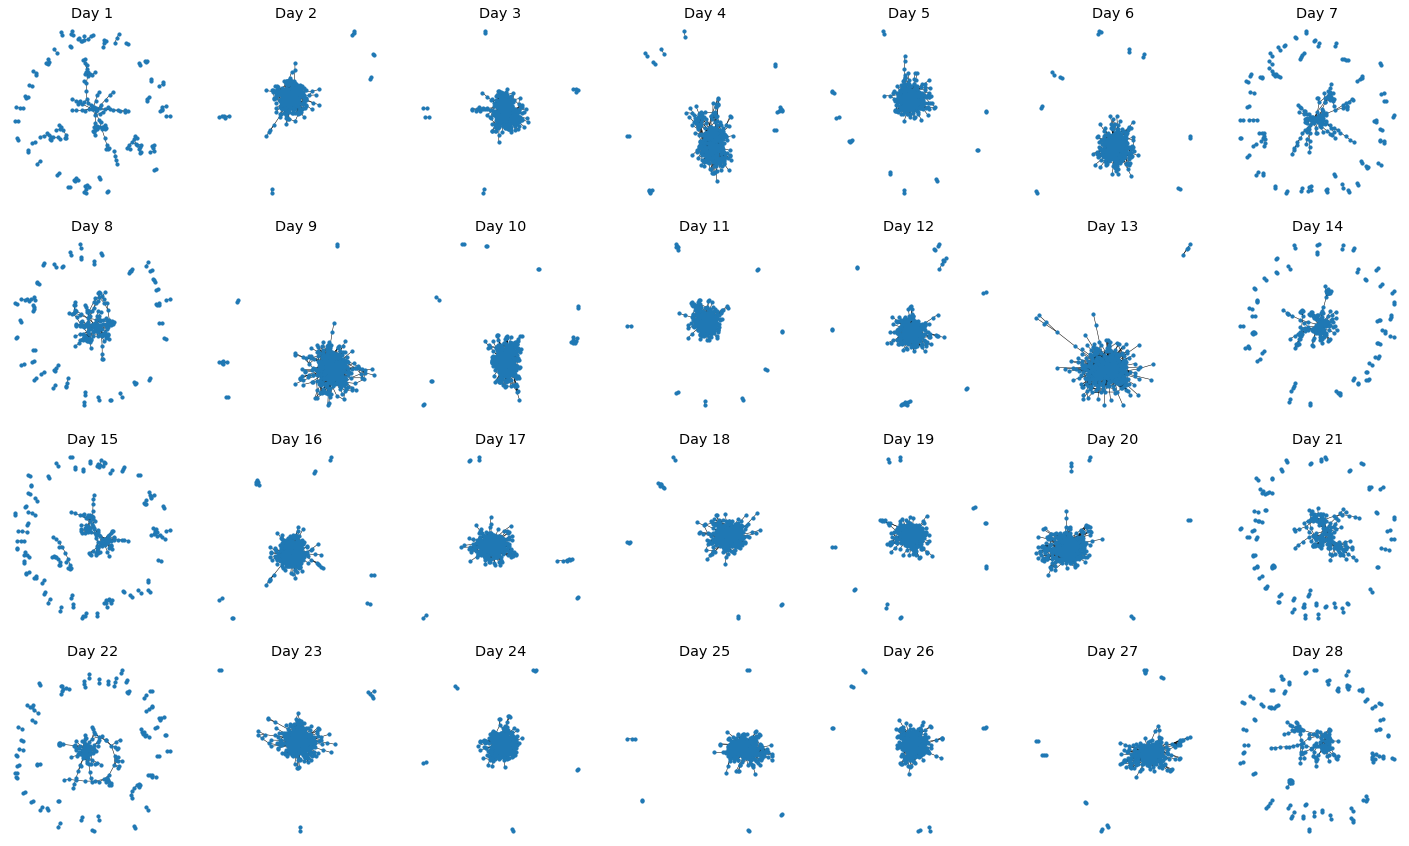

In [27]:
days = sorted(stats.keys())

mpl.rcParams['axes.titlesize'] = 'x-large'
mpl.rcParams['axes.labelsize'] = 'x-large'

# plot networks
plt.figure(figsize=(25, 15))
for (i, day) in enumerate(days):
    plt.subplot(4,7,i+1)
    nx.draw(Gs[day], node_size=10, width=0.5)
    plt.title("Day " + str(day+1))
plt.savefig('CNS_Networks_byDay.eps', format = 'eps');

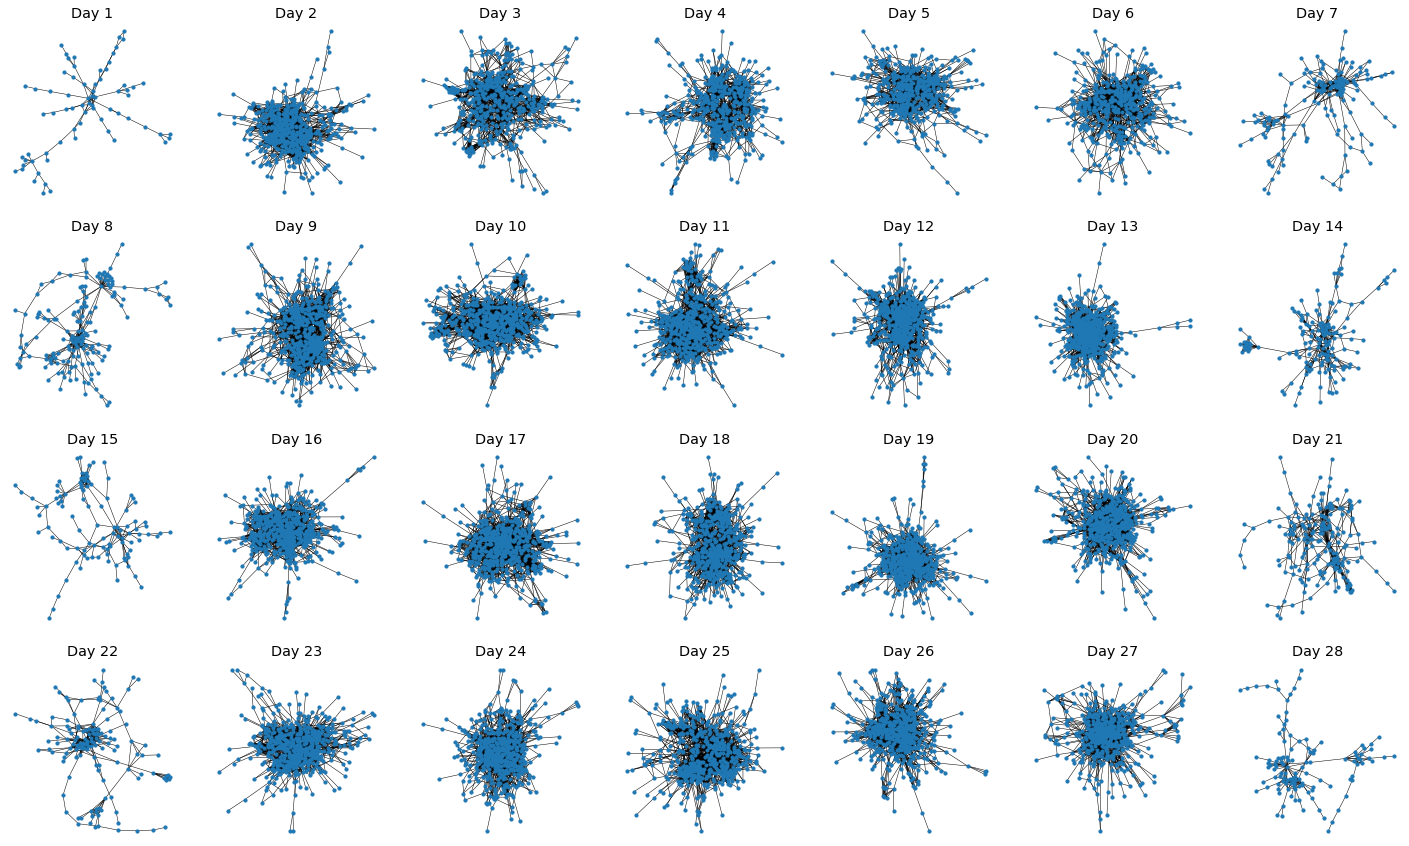

In [28]:
# plot LCCs
plt.figure(figsize=(25, 15))
for (i, day) in enumerate(days):
    plt.subplot(4,7,i+1)
    lcc = max(nx.connected_components(Gs[day]), key=len)
    nx.draw(Gs[day].subgraph(lcc), node_size=10, width=0.5)
    plt.title("Day " + str(day+1))
plt.savefig('CNS_LCCs_byDay.eps', format = 'eps');